<a href="https://colab.research.google.com/github/sfmajors373/FourthBrainBreastCancer/blob/seg_UNet_update/simple_unet_update.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
#Load the libraries
import numpy as np
import tensorflow as tf
from keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, UpSampling2D
from keras.layers.merge import concatenate
from tensorflow.nn import local_response_normalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt
from datetime import datetime

In [77]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import os
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import h5py
import math
import pickle
from datetime import datetime
from numba import cuda 

%matplotlib inline

In [78]:
import sys  
sys.path.insert(0, '/content/drive/MyDrive/Colab Notebooks/CancerMap')

In [79]:
!pip install progress 

In [80]:
from tiling.read_tiles_with_mask import TissueDataset, load_color_normalization_values

In [81]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [82]:
dim_tiles = 256
depth = 3

In [83]:
def unet(layer_in = Input(shape=(dim_tiles, dim_tiles, depth))):
    inputs = layer_in
    
    conv1 = Conv2D(64, 3, activation = 'relu',padding = 'same', kernel_initializer = 'he_normal',dilation_rate=2)(inputs) #dilation_rate=2 etc.
    conv1 = Conv2D(64, 3, activation = 'relu',padding = 'same', kernel_initializer = 'he_normal',dilation_rate=2)(conv1) #dilation_rate=2 etc.
    # conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(pool1)
    # conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', dilation_rate=2, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    # conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    # conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    # conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    # conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    # conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)#training=True will enable dropout for test data
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    # conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    # conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5) 

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)    

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8) 

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    model = Model(inputs = inputs, outputs = conv10)
    return model

In [84]:
model = unet()

In [85]:
HDF5_FOLDER = '/content/drive/MyDrive/Colab Notebooks/CancerMap/train'

In [86]:
color_normalization_json = "CAMELYON16_color_normalization.json"

In [87]:
log_dir = "/media/nico/data/fourthbrain/project/unet_testing/" + datetime.now().strftime("%Y%m%d-%H%M%S")

In [88]:
train_data = TissueDataset(HDF5_FOLDER,  percentage=0.8, first_part=True, crop_size=256)
val_data = TissueDataset(HDF5_FOLDER, percentage=0.2, first_part=False, crop_size=256)

In [89]:
a, b = train_data.get_batch()

(array([[[[0.7254902 , 0.44705882, 0.57254902],
         [0.63137255, 0.36078431, 0.48235294],
         [0.68627451, 0.41176471, 0.54509804],
         ...,
         [0.61568627, 0.36470588, 0.47058824],
         [0.83921569, 0.58039216, 0.69019608],
         [0.88235294, 0.62352941, 0.73333333]],

        [[0.52941176, 0.23529412, 0.36470588],
         [0.5254902 , 0.23529412, 0.36470588],
         [0.64705882, 0.36862745, 0.49411765],
         ...,
         [0.9372549 , 0.68627451, 0.79215686],
         [0.86666667, 0.60784314, 0.71764706],
         [0.80784314, 0.54901961, 0.65882353]],

        [[0.79607843, 0.48235294, 0.61960784],
         [0.91764706, 0.62352941, 0.75294118],
         [1.        , 0.73333333, 0.84705882],
         ...,
         [0.30980392, 0.05882353, 0.16470588],
         [0.76078431, 0.50196078, 0.61176471],
         [0.79215686, 0.54117647, 0.64705882]],

        ...,

        [[0.44313725, 0.25098039, 0.36862745],
         [1.        , 0.90980392, 1.        

In [90]:
len(a)

2

In [91]:
len(b)

10

In [92]:
np.array(a[0][0]).shape

(256, 256, 3)

In [93]:
np.array(a[1][9]).shape

(256, 256, 1)

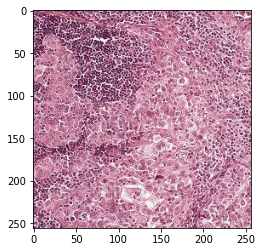

In [94]:
test = np.array(a[0][0])
test = tf.squeeze(test)
test.shape
plt.imshow(test)

In [ ]:
batch_size=1
batches_per_train_epoch = 1
batches_per_val_epoch = 1
MAX_EPOCHS = 5

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
history = model.fit(a, epochs= 5, batch_size= 1)

Epoch 1/5


ValueError: ignored

In [ ]:
history = model.fit(train_data.generator(batch_size, True, green_layer_only=False, color_normalization_file=color_normalization_json),
                    validation_data=val_data.generator(batch_size, False, green_layer_only=False, color_normalization_file=color_normalization_json),
                    epochs=MAX_EPOCHS,
                    steps_per_epoch = batches_per_train_epoch,
                    validation_steps = batches_per_val_epoch)

File not accessible
(array([[[[0.89019608, 0.6       , 0.72941176],
         [0.78039216, 0.50196078, 0.61960784],
         [0.97254902, 0.70196078, 0.81568627],
         ...,
         [0.91764706, 0.74901961, 0.82352941],
         [0.85882353, 0.69803922, 0.76862745],
         [0.94117647, 0.78823529, 0.85882353]],

        [[0.59607843, 0.29411765, 0.41960784],
         [0.98431373, 0.69019608, 0.81176471],
         [0.69411765, 0.4       , 0.52156863],
         ...,
         [0.8745098 , 0.74117647, 0.79607843],
         [0.87843137, 0.75294118, 0.81176471],
         [0.87058824, 0.74901961, 0.80784314]],

        [[0.52156863, 0.22745098, 0.34901961],
         [0.61176471, 0.3254902 , 0.44313725],
         [0.74117647, 0.44705882, 0.56470588],
         ...,
         [1.        , 0.88235294, 0.92941176],
         [0.90588235, 0.79607843, 0.85098039],
         [0.90196078, 0.8       , 0.85098039]],

        ...,

        [[0.87058824, 0.63529412, 0.7372549 ],
         [0.49019608, 0.

TypeError: ignored

In [ ]:
now1 = datetime.now()
model_type = 'unet'
model_hdf5 = '/media/nico/data/fourthbrain/project/model_testing/model_{}_'.format(model_type) + now1.strftime("%Y%m%d-%H%M%S") + '.hdf5'
filepath = '/media/nico/data/fourthbrain/project/model_testing/{}.pkl'.format(model_type)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_hdf5, monitor='loss',verbose=1, save_best_only=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, 
                           verbose=1, mode='max', min_lr=1e-5)

#all callbacks
callbacks = [tensorboard_callback, model_checkpoint, reduce_lr]        
history = model.fit(x=train_data.generator(batch_size_neg, batch_size_pos, True, green_layer_only=False, color_normalization_file=color_normalization_json),
                    validation_data=val_data.generator(batch_size_neg, batch_size_pos, False, green_layer_only=False, color_normalization_file=color_normalization_json),
                    epochs=MAX_EPOCHS,
                    steps_per_epoch = batches_per_train_epoch,
                    validation_steps = batches_per_val_epoch,
                    callbacks=callbacks
                   )
dtme = now1.strftime('%m%d%Y_%H%M%S.pkl')
now2 = datetime.now()
print('duration: {} - path: {}'.format(now2 - now1, filepath))
history_to_pickle(history, filepath)

/home/nico/miniconda3/envs/nightly/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


ValueError: could not broadcast input array from shape (50,256,256,3) into shape (50,256,256)

In [ ]:
import h5py
import os
cancer_image = []
cancer_mask = []
cancer_image_path = HDF5_FOLDER
filename_X = os.listdir(cancer_image_path+'/X/')
filename_y = os.listdir(cancer_image_path+'/y/')
for f in filename_X:
  image = h5py.File(cancer_image_path+'/X/'+f, 'r')
  image_name = list(image.keys())
  image_name = image_name[0]
  if image_name[0] == 't':
    data = image.get(image_name).value # data is now an ndarray. double check here. What is the dictionary key called?
    cancer_image.append(data)

for f in filename_y:
  image = h5py.File(cancer_image_path+'/y/'+f, 'r')
  image_name = list(image.keys())
  image_name = image_name[0]
  if image_name[0] == 't':
    data = image.get(image_name).value # data is now an ndarray. double check here. What is the dictionary key called?
    cancer_mask.append(data)
  




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


In [ ]:
for a, b in train_data.get_batch(2):
    a = a
    b = b

(array([[[[0.44313725, 0.20392157, 0.3372549 ],
         [0.5372549 , 0.28627451, 0.43137255],
         [0.32156863, 0.07058824, 0.21568627],
         ...,
         [0.92156863, 0.69411765, 0.78039216],
         [0.69803922, 0.48235294, 0.56470588],
         [0.94117647, 0.73333333, 0.81176471]],

        [[0.55686275, 0.31764706, 0.45098039],
         [0.58431373, 0.33333333, 0.47843137],
         [0.44705882, 0.20392157, 0.34901961],
         ...,
         [0.7372549 , 0.48627451, 0.58039216],
         [0.83137255, 0.58823529, 0.67843137],
         [0.78823529, 0.56078431, 0.64705882]],

        [[0.58039216, 0.34117647, 0.4745098 ],
         [0.74901961, 0.49803922, 0.64313725],
         [0.41176471, 0.17647059, 0.31764706],
         ...,
         [0.65882353, 0.40392157, 0.49803922],
         [0.75294118, 0.50196078, 0.59607843],
         [0.85098039, 0.60784314, 0.69803922]],

        ...,

        [[0.81176471, 0.64313725, 0.72156863],
         [1.        , 0.90980392, 0.98431373